In [1]:
import collections
import os
import pickle

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import transformers

from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def textbf(text):
    return '\033[1m' + text + '\033[0m'

def textcolor(text, color):
    code = {'red': '31', 'green': '32', 'yellow': '33', 'blue': '34', 'magenta': '35', 'cyan': '36', 'white': '37'}
    return '\033[' + code[color] + 'm' + text + '\033[0m'

In [3]:
data_dir = '../data/N2C2-Track3-May3_pseudo/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'), low_memory=False)
print(f'Train {len(df_train)} rows')
df_dev = pd.read_csv(os.path.join(data_dir, 'dev.csv'), low_memory=False)
print(f'Dev {len(df_dev)} rows')

Train 4633 rows
Dev 597 rows


In [4]:
_relation_labels = {'Direct': 0, 'Indirect': 1, 'Neither': 2, 'Not Relevant': 3}
relations, labels = list(zip(*_relation_labels.items()))
relation_to_label = _relation_labels
label_to_relation = {v: k for k, v in relation_to_label.items()}
num_labels = len(relation_to_label)

## Accuracy / conf matrix

In [5]:
def confusion_matrix_strs(y_true, y_pred, dataset=''):
    conf_mat = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    results = []
    results.append(f'{dataset.upper():<9}' + ' '.join([f'{r[:8]:>8}' for r in relations]) + '  Lbl cnt')
    for i in range(4):
        results.append(f'{relations[i][:8]:>8} ' + ' '.join([f'{c:8}' for c in conf_mat[i]]) + f' {sum(conf_mat[i]):8}')    
    results.append(f'Pred cnt ' + ' '.join([f'{sum(conf_mat[:,i]):8}' for i in range(4)]) + f' {np.sum(conf_mat):8}')    
    return results

def plot_confusion_matrix_traindev(results_dir):
    print(f'[Experiment {results_dir}]')
    
    train_labels = np.array([relation_to_label[row['Relation']] for _, row in df_train.iterrows()])
    dev_labels = np.array([relation_to_label[row['Relation']] for _, row in df_dev.iterrows()])
    with open(os.path.join(results_dir, 'results_train_9999.pkl'), 'rb') as fd:
        train_results = pickle.load(fd)
    with open(os.path.join(results_dir, 'results_dev_9999.pkl'), 'rb') as fd:
        dev_results = pickle.load(fd)
    train_preds = np.argmax(np.array([r['logits'] for r in train_results]), axis=1)
    dev_preds = np.argmax(np.array([r['logits'] for r in dev_results]), axis=1)

    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true=train_labels, y_pred=train_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Train prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))
    ax = plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true=dev_labels, y_pred=dev_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Dev prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))

    train_correct = train_labels == train_preds
    dev_correct = dev_labels == dev_preds
    print(f'- Train set performance')
    print(f'    - Accuracy: {np.mean(train_correct):.6f} ({sum(train_correct)}/{len(train_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=train_labels, y_pred=train_preds, average="macro"):.6f}')
    print(f'- Dev set performance')
    print(f'    - Accuracy: {np.mean(dev_correct):.6f} ({sum(dev_correct)}/{len(dev_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"):.6f}')
    
    train_conf_strs = confusion_matrix_strs(train_labels, train_preds, 'train')
    dev_conf_strs = confusion_matrix_strs(dev_labels, dev_preds, 'dev')
    for str1, str2 in zip(train_conf_strs, dev_conf_strs):
        print(str1 + ' | ' + str2)

[Experiment ../results/sent_rel_PubMedBERT_pseudo/]
- Train set performance
    - Accuracy: 0.997842 (4623/4633)
    - Macro F1: 0.997913
- Dev set performance
    - Accuracy: 0.748744 (447/597)
    - Macro F1: 0.766857
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      119       19        5        2      145
Indirect        8     1240        1        0     1249 | Indirect       27      106       43        3      179
 Neither        0        1     1483        0     1484 |  Neither        5       33      134        1      173
Not Rele        0        0        0      810      810 | Not Rele        6        3        3       88      100
Pred cnt     1098     1241     1484      810     4633 | Pred cnt      157      161      185       94      597


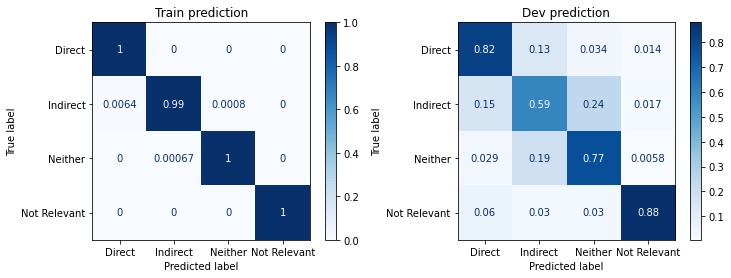

In [6]:
plot_confusion_matrix_traindev('../results/sent_rel_PubMedBERT_pseudo/')

[Experiment ../results/sent_rel_BlueBERT-Large_pseudo/]
- Train set performance
    - Accuracy: 0.998273 (4625/4633)
    - Macro F1: 0.998296
- Dev set performance
    - Accuracy: 0.738693 (441/597)
    - Macro F1: 0.763730
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1088        2        0        0     1090 |   Direct      106       31        5        3      145
Indirect        1     1248        0        0     1249 | Indirect       13      137       28        1      179
 Neither        0        3     1481        0     1484 |  Neither        2       60      111        0      173
Not Rele        1        0        1      808      810 | Not Rele        2        6        5       87      100
Pred cnt     1090     1253     1482      808     4633 | Pred cnt      123      234      149       91      597


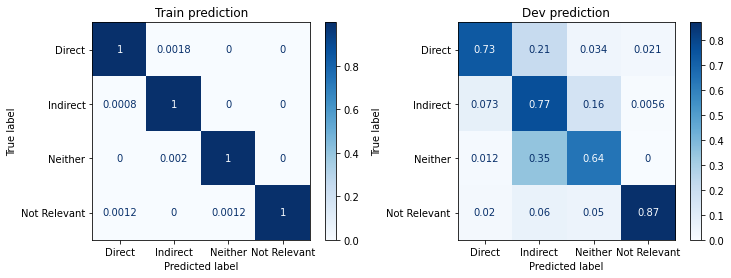

In [7]:
plot_confusion_matrix_traindev('../results/sent_rel_BlueBERT-Large_pseudo/')

## Examples / results

In [8]:
results_dir = '../results/sent_rel_PubMedBERT_pseudo/'
ckpt_step = 9999

with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
    train_results = pickle.load(fd)
with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
    dev_results = pickle.load(fd)
    
assert len(train_results) == len(df_train)
assert len(dev_results) == len(df_dev)

In [9]:
tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

In [10]:
def print_example(idx, dataset='train'):
    if dataset == 'train':
        row = df_train.iloc[idx]
    elif dataset == 'dev':
        row = df_test.iloc[idx]
    else:
        raise ValueError(f'Wrong dataset: {dataset}')
        
    row_id, hadm_id, assessment, plan, relation = \
        (row['ROW ID'], row['HADM ID'], row['Assessment'], row['Plan Subsection'], row['Relation'])
    print(f'[{dataset.upper()} example #{idx}, ROW_ID:{row_id:7}, HADM_ID:{hadm_id:7}]')
    num_assess_tokens = len(tokenizer.encode(assessment, add_special_tokens=False))
    print(f'- Assessment ({num_assess_tokens} tokens): \n{assessment}')
    num_plan_tokens = len(tokenizer.encode(plan, add_special_tokens=False))
    print(f'- Plan Subsection ({num_plan_tokens} tokens): \n{plan}')
    print(f'- Relation: {relation} (label {relation_to_label[relation]})')

In [11]:
print_example(0)

[TRAIN example #0, ROW_ID: 701359, HADM_ID: 186454]
- Assessment (53 tokens): 
51 yr old F with a history of 3V CAD, confirmed on C. cath during this
   admission, EF of 40%, who is transferred to CCU for monitoring of
   recurrent chest pain. Plan for CABG today to revascularize due to
   3-vessel disease.
- Plan Subsection (124 tokens): 
# CORONARIES: Patient with 3 vessel disease on cath. Previously found
   to be the case in 2174, but had been treated medically. On the floor,
   patient with recurrent chest pain and EKG changes, concerning for
   further ischemia. Chest pain has been controlled on nitro gtt. Patient
   in CCU for monitoring; plan for CABG today.
   - continue nitro gtt
   - if has further CP, would uptitrate nitro, and contact KINNAMAN and
   attending for potential balloon pump vs. urgent CABG
   - appreciate CT NENITA recs
   - continue KONOPNICKI, LESLIE, ACE-i, simvastatin
- Relation: Direct (label 0)


In [12]:
def print_results(idx, dataset='train'):
    if dataset == 'train':
        row, result = df_train.iloc[idx], train_results[idx]
    elif dataset == 'dev':
        row, result = df_dev.iloc[idx], dev_results[idx]
    else:
        raise ValueError(f'Wrong dataset: {dataset}')
    
    row_id, hadm_id, assessment, plan, relation = \
        (row['ROW ID'], row['HADM ID'], row['Assessment'], row['Plan Subsection'], row['Relation'])
    assert row_id == result['row_id'] and hadm_id == result['hadm_id'] and relation_to_label[relation] == result['label']
    logits = result['logits']
    probs = np.exp(logits) / np.sum(np.exp(logits))
    pred = np.argmax(logits)
    correct = pred == relation_to_label[relation]
    color = "green" if correct else "red"
        
    print(f'[{dataset.upper()} example #{idx}, ROW_ID:{row_id:7}, HADM_ID:{hadm_id:7}]')
    num_assess_tokens = len(tokenizer.encode(assessment, add_special_tokens=False))
    print(f'- Assessment ({num_assess_tokens} tokens): \n{assessment}')
    num_plan_tokens = len(tokenizer.encode(plan, add_special_tokens=False))
    print(f'- Plan Subsection ({num_plan_tokens} tokens): \n{plan}')
    print(f'- Relation  : {relation} (label {relation_to_label[relation]})')
    print(f'- Prediction: {textcolor(label_to_relation[pred] + " (label " + str(pred) + ")", color)}')\
    
    for i in range(4):
        prob_str = f'  {i}) {label_to_relation[i]:>12} {probs[i]:.4f}'
        print(textbf(prob_str) if i == pred else prob_str)
    

In [13]:
print_results(0, 'dev')

[DEV example #0, ROW_ID: 576487, HADM_ID: 112508]
- Assessment (51 tokens): 
A 60 year old woman with recurrent ALL with CNS involvement s/p Omaya
   removal due to VRE contamination & SDH evacuation.  She is now doing
   well and awake s/p extubation, afebrile and her WBC count is trending
   downward.
- Plan Subsection (91 tokens): 
CNS VRE:  S/P Omaya removal, on linezolid for greater CNS penetration
   despite risk of CNS penetration. No TEE performed.
   - continue linezolid (D1=4-16), course to be determined by TEE (4 vs 8
   weeks) gentamicin D/C
d per ID
   - f/u culture data and sensitivities
   - TEE deferred at this time.
   - f/u tigacycline sensitivities for long-term therapy
- Relation  : Direct (label 0)
- Prediction: Direct (label 0)
  0)       Direct 1.0000
  1)     Indirect 0.0000
  2)      Neither 0.0000
  3) Not Relevant 0.0000


In [14]:
print_results(2, 'dev')

[DEV example #2, ROW_ID: 576487, HADM_ID: 112508]
- Assessment (51 tokens): 
A 60 year old woman with recurrent ALL with CNS involvement s/p Omaya
   removal due to VRE contamination & SDH evacuation.  She is now doing
   well and awake s/p extubation, afebrile and her WBC count is trending
   downward.
- Plan Subsection (70 tokens): 
ALL:  Currently day +43 s/p hyper-CVAD.  She is also s/p intrathecal
   MTX and DLI this admission.  Per BMT, will need further treatment for
   CNS lymphoma in the future.
   - f/u BMT recommendations
   - follow CBC/diff
   - continue acyclovir, micafungin in addition to linezolid
- Relation  : Indirect (label 1)
- Prediction: Direct (label 0)
  0)       Direct 0.9981
  1)     Indirect 0.0019
  2)      Neither 0.0000
  3) Not Relevant 0.0000
